In [1]:
import torch
import torch.utils.data 
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torchvision import datasets, models, transforms

## Preprocessing the Data

In [2]:
train_path = "images/train"
test_path = "images/test"
labels = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

In [3]:
# Applying transforms
train_data_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

test_data_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

In [4]:
# Loading the datasets with ImageFolder
dataset = datasets.ImageFolder(train_path, transform=train_data_transforms)
train_dataset, valid_dataset, _ = torch.utils.data.random_split(dataset, [0.2, 0.05, 0.75])
print(len(train_dataset), len(valid_dataset))

test_dataset = datasets.ImageFolder(test_path, transform=test_data_transforms)

# Defining dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

print(len(train_loader))

6201 1550
97


torch.Size([3, 224, 224])
Label: angry


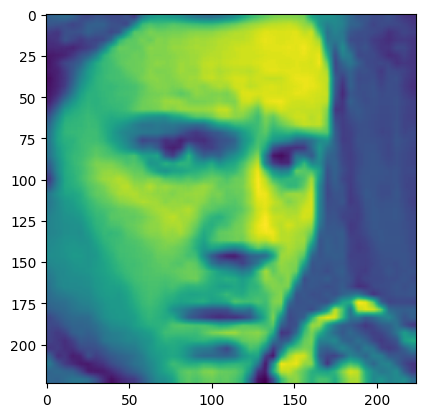

In [21]:
# Sample image and label
sample_image = dataset[0][0]
print(sample_image.shape)

plt.imshow(sample_image[0])
print("Label:", labels[dataset[0][1]])

## Training the Model

In [6]:
model = models.vgg11(weights="DEFAULT")

In [7]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [8]:
# Freezing layers
for param in model.parameters(): 
    param.requires_grad = False

# Defining a custom classifier with 7 output classes
classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(4096, 2048),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(p = 0.3),
    nn.Linear(512, 7),
    nn.LogSoftmax(dim=1)
)

model.classifier = classifier

In [9]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.0005)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [10]:
def validation(model, valid_loader, criterion):
    valid_loss = 0
    accuracy = 0
    
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        output = model.forward(inputs)
        valid_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return valid_loss, accuracy

In [11]:
model.load_state_dict(torch.load("fer_model.pt"))

<All keys matched successfully>

In [ ]:
epochs = 2
print_every = 40
steps = 0

for e in range(epochs): 
    running_loss = 0
    
    for _, (inputs, labels) in enumerate(train_loader):
        steps += 1
        if steps % 10 == 0: print(f"Step: {steps}")
        inputs, labels = inputs.to(device), labels.to(device)
    
        optimizer.zero_grad()
    
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels) 
        loss.backward() 
        optimizer.step() 
    
        running_loss += loss.item () 
    
        if steps % print_every == 0:
            model.eval() 
            
            with torch.no_grad():
                valid_loss, accuracy = validation(model, valid_loader, criterion)
            
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss / print_every),
                  "Valid Loss: {:.3f}.. ".format(valid_loss / len(valid_loader)),
                  "Valid Accuracy: {:.3f}%".format(accuracy / len(valid_loader) * 100))
            
            running_loss = 0
            model.train()

Step: 10
Step: 20
Step: 30


In [28]:
torch.save(model.state_dict(), "fer_model.pt")